# Homework 3: Actor-Critic Algorithm and Dyna-Q algorithm

## Due: 23:59:59 (GMT +08:00), April 18, 2024

**The homework contains two parts: Actor-Critic algorithm and Dyna-Q algorithm. You need to implement the two algoithms and answer the questions.**

# Section 1. Dyna-Q and Dyna-Q+

### Environment: Maze problem

In the first simple maze problem shown in Figure 1 (**basic**), there are four actions, **up**, **down**, **right**, and **left**, which take the agent deterministically to the corresponding neighboring states, except when movement is blocked by an obstacle or the outer boundary of the maze, in which case the agent remains where it is. 

Reward is zero on all state-action pairs, except those transiting to the goal state, on which the reward is **+1**, i.e., **r(s, a) = 1** when the **next state s′ = G** and **r(s, a) = 0 otherwise**.

After reaching the goal state (G), the agent returns to the start state (S) to begin a new episode.

!["figure 1"](./pic1.png)

*Figure 1*

In the second blocking maze problem (**blocking**) shown in Figure 2, initially, there is a short path from start to goal, along the right-hand side boundary of the maze, as shown in the left subfigure of Figure 2. 

After 5000 time steps, the short path is “blocked”, and a longer path is opened up along the left-hand side boundary of the maze, as shown in the right subfigure of Figure 2. Other basic settings are the same as the first simple maze problem.

!["figure 2"](./pic2.png)

*Figure 2*

In the third shortcut maze problem (**cut**) shown in Figure 3, initially, the optimal path is to go around the left side of the boundary (left subfigure of Figure 3). 

After 3000 time steps, however, a shorter path is opened up along the right side, without changing the original path (right subfigure of Figure3). And other basic settings are the same as the first problem.

!["figure 3"](./pic3.png)

*Figure 3*


In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Maze:
    def __init__(self, ncol=9, nrow=6, model="basic"):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0              # the current position (x) of agent 
        self.y = self.nrow - 1  # the current position (y) of agent
        self.time_counter = 0
        self.model = model
        if model == "basic":
            self.barrier = [[2, 2], [2, 3], [2, 4], [5, 1], [7, 3], [7, 4], [7, 5]]
            self.start = [0, 3]
            self.end = [8, 5]
        elif model == "blocking":
            self.barrier = [[0, 2], [1, 2], [2, 2], [3, 2], [4, 2], [5, 2], [6, 2], [7, 2]]
            self.start = [3, 0]
            self.end = [8, 5]
        elif model == "cut":
            self.barrier = [[8, 2], [1, 2], [2, 2], [3, 2], [4, 2], [5, 2], [6, 2], [7, 2]]
            self.start = [3, 0]
            self.end = [8, 5]

    def step(self, action):
        # 4 kinds of actions: change[0]: up, change[1]: down, change[2]: left, change[3]: right
        # original (0, 0) on the top left
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        newx = min(self.ncol - 1, max(0, self.x + change[action][0]))
        newy = min(self.nrow - 1, max(0, self.y + change[action][1]))
        if [newx, newy] not in self.barrier:
            self.x = newx
            self.y = newy
        next_state = self.y * self.ncol + self.x
        done = False
        reward = 0
        if self.x == self.end[0] and self.y == self.end[1]: # next position is the terminal
            done = True
            reward = 1
        self.time_counter += 1
        if self.model == "blocking" and self.time_counter > 5000:
            self.barrier = [[8, 2], [1, 2], [2, 2], [3, 2], [4, 2], [5, 2], [6, 2], [7, 2]]
        if self.model == "cut" and self.time_counter > 3000:
            self.barrier = [[1, 2], [2, 2], [3, 2], [4, 2], [5, 2], [6, 2], [7, 2]]
        return next_state, reward, done

    def reset(self):
        self.x = self.start[0]
        self.y = self.start[1]
        return self.y * self.ncol + self.x

### In this part, we try to implement two algorithms: (A) Dyna-Q and (B) Dyna-Q+

#### Dyna-Q

The Dyna-Q algorithm is to repeat the following steps: (1) Learning and (2) Planning

Learning step is the same as Q-learning. At current state $S$, we take action $A$ with $\epsilon$-greedy policy, then we get rewards $R$ and next state $S'$ from environment. We update the Q-table by the following formula: 
$$ Q(S,A)\leftarrow Q(S,A)+\alpha[R+\gamma \max_{a} Q(S',a)- Q(S,A)] $$

Then we predict state transition as following:
$$ \text{Model}(S,A) \leftarrow R,S' $$

Planning does not need to interact with the environment, every planning step samples a visited pair $(S,A)$ firstly, obtain relevant $(R,S')$ from $\text{Model}(S,A)$, and update Q-table by following formula, the planning step will repeat $n$ times:
$$ Q(S,A)\leftarrow Q(S,A)+\alpha[R+\gamma \max_{a} Q(S',a)- Q(S,A)] $$

**Coding exercise.** Here you are required to complete `q_learning` and `update` in class `DynaQ`.

In [3]:
class DynaQ:
    """ Dyna-Q """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_planning, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])    # initial Q table
        self.n_action = n_action                            # number of actions
        self.alpha = alpha                                  # learning rate
        self.gamma = gamma                                  # discount factor
        self.epsilon = epsilon                              # epsilon-greedy
        self.n_planning = n_planning                        # number of times to conduct q-planning
        self.model = {(s, a): (0, s) for s in range(nrow * ncol) for a in range(n_action)}
                                                            # environment model

    def check(self, state):
        return self.Q_table[state][0] == self.Q_table[state][1] == self.Q_table[state][2] == self.Q_table[state][3]

    def take_action(self, state):
        if np.random.random() < self.epsilon or self.check(state):
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def q_learning(self, s0, a0, r, s1):
        """ ------------- Programming 1: implement the updating of the Q table for Q-learning ------------- """
        self.Q_table[s0][a0] += self.alpha * (r + self.gamma * np.max(self.Q_table[s1]) - self.Q_table[s0][a0])
        """ ------------- Programming 1 ------------- """

    def update(self, s0, a0, r, s1):
        """ ------------- Programming 2: implement the updating of the Q table for Dyna-Q (you may use the function q_learning) ------------- """
        self.q_learning(s0, a0, r, s1)
        self.model[(s0, a0)] = (r, s1)
        for _ in range(self.n_planning):
            s0, a0 = random.choice(list(self.model.keys()))
            r, s1 = self.model[(s0, a0)]
            self.q_learning(s0, a0, r, s1)
        """ ------------- Programming 2 ------------- """

#### Dyna-Q+

Dyna-Q+ is similar to Dyna-Q, the only difference between them is the reward function in planning step. We take a new reward $r = r + c \sqrt t$, where $c$ is an exploration factor and $t$ is the time since the agent last reached state $S$.

**Coding exercise.** Simiarily, you are require to complete `q_learning` and `update` in class `DynaQ_Plus`.

In [4]:
class DynaQ_Plus:
    """ Dyna-Q+ """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, kappa, n_planning, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])    # initial Q table
        self.n_action = n_action                            # number of actions
        self.alpha = alpha                                  # learning rate
        self.gamma = gamma                                  # discount factor
        self.epsilon = epsilon                              # epsilon-greedy
        self.n_planning = n_planning                        # number of times to conduct q-planning
        self.model = {(s, a): (0, s, 0) for s in range(nrow * ncol) for a in range(n_action)}
                                                            # environment model
        self.time = 0                                       # update time
        self.kappa = kappa                                  # exploration factor

    def check(self, state):
        return self.Q_table[state][0] == self.Q_table[state][1] == self.Q_table[state][2] == self.Q_table[state][3]

    def take_action(self, state):
        if np.random.random() < self.epsilon or self.check(state):
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def q_learning(self, s0, a0, r, s1):
        """ ------------- Programming 1: implement the updating of the Q table for Q-learning ------------- """
        self.Q_table[s0][a0] += self.alpha * (r + self.gamma * np.max(self.Q_table[s1]) - self.Q_table[s0][a0])
        """ ------------- Programming 1 ------------- """

    def update(self, s0, a0, r, s1):
        """ ------------- Programming 2: implement the updating of the Q table for DynaQ (you may use the function q_learning) ------------- """
        self.q_learning(s0, a0, r, s1)
        self.model[(s0, a0)] = (r, s1, self.time)
        for _ in range(self.n_planning):
            s0, a0 = random.choice(list(self.model.keys()))
            r, s1, t = self.model[(s0, a0)]
            self.q_learning(s0, a0, r + self.kappa * np.sqrt(self.time - t), s1)
        self.time += 1
        """ ------------- Programming 2 ------------- """

## Running two algorithms in the maze environment and visualization

Here, we try to run two algorithms in our environment. You should run the following code without editing and answer **Questions 1** based on the output. **Your output will be one of the criteria we use to score**.

You can also change the hyperparameters privately to get a better understanding of these two algorithms.

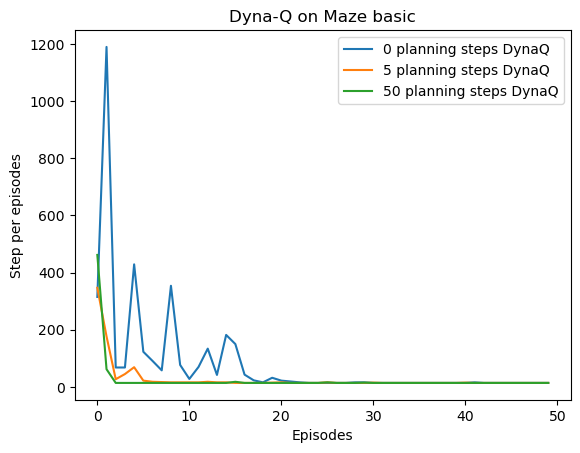

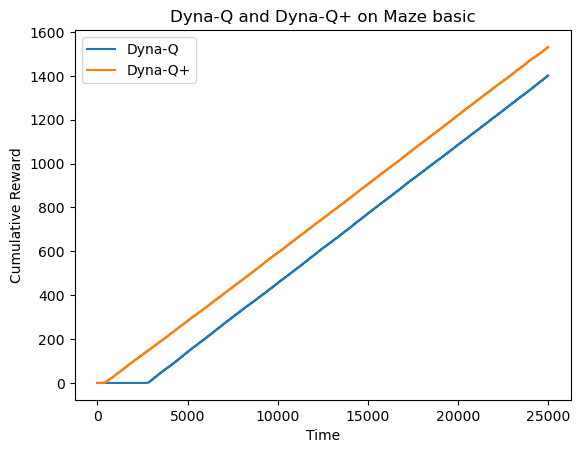

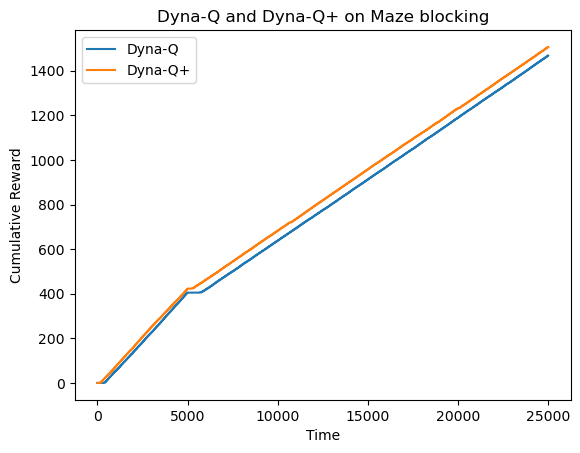

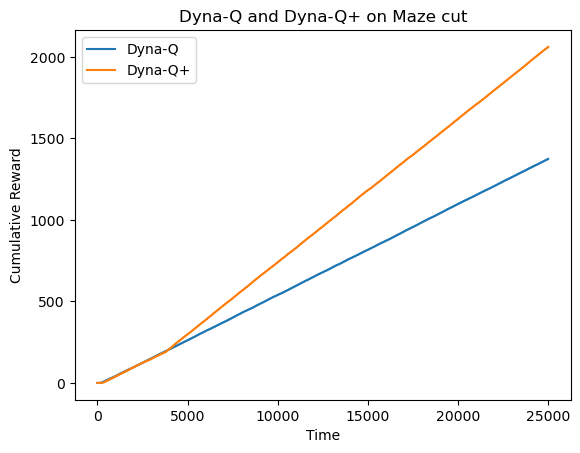

In [7]:
SEED = 6
random.seed(SEED)
np.random.seed(SEED)
maze_list = ["basic", "blocking", "cut"]
agent_list = ["Dyna-Q", "Dyna-Q+"]
n_planning_list = [0, 5, 50]
ncol = 9
nrow = 6

# Part 1: We are going to analyse the impact of "n_planing", we take this part in maze "basic" and agent "DynaQ"
epsilon = 0.01      # epsilon-greedy
alpha = 0.1         # learning rate
gamma = 0.95        # discount factor
kappa = 1e-3        # exploration factor
num_episodes = 50   # number of episodes
plt.figure()
for n_planning in n_planning_list:
    env = Maze(ncol, nrow, model="basic")
    agent_name = "DynaQ"
    agent = DynaQ(ncol, nrow, epsilon, alpha, gamma, n_planning)
    steps_list = []
    for i_episode in range(num_episodes):
        state = env.reset()
        done = False
        t_count = 0
        while not done:
            action = agent.take_action(state)
            next_state, reward, done = env.step(action)
            t_count += 1
            agent.update(state, action, reward, next_state)
            state = next_state
        steps_list.append(t_count)
    episodes_list = list(range(len(steps_list)))
    plt.plot(episodes_list, steps_list, label=str(n_planning) + ' planning steps '+ str(agent_name))
plt.xlabel('Episodes')
plt.ylabel('Step per episodes')
plt.title('Dyna-Q on {}'.format("Maze basic"))
plt.legend()
plt.show()

# Part 2: We are going to analyse the difference between agent "DynaQ" and agent "DynaQ+"
epsilon = 0.1
alpha = 1
gamma = 0.95
n_planning = 20
num_episodes = 20
for maze in maze_list:
    plt.figure()
    for agent_type in agent_list:
        env = Maze(ncol, nrow, model=maze)  
        if agent_type == "Dyna-Q":
            agent = DynaQ(ncol, nrow, epsilon, alpha, gamma, n_planning)
        elif agent_type == "Dyna-Q+":
            agent = DynaQ_Plus(ncol, nrow, epsilon, alpha, gamma, kappa, n_planning)
        time_step = 0
        cumulative_reward = np.zeros(25000)
        while time_step < 25000:
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                time_step += 1
                if time_step >= 25000:
                    break
                cumulative_reward[time_step] = cumulative_reward[time_step - 1] + reward
                agent.update(state, action, reward, next_state)
                state = next_state
        time_list = list(range(len(cumulative_reward)))
        plt.plot(time_list, cumulative_reward, label=agent_type)
    plt.xlabel('Time')
    plt.ylabel('Cumulative Reward')
    plt.title('Dyna-Q and Dyna-Q+ on {}'.format("Maze " + maze))
    plt.legend()
    plt.show()

**Questions.**

* What are the impacts of the number of planning steps on the performances of algorithms and what is the reason?
  * From the curves we can see that larger number of planning steps accelerate the convergence of the algorithms. Without planning, it takes about $20$ episodes for the agent to find the optimal path. With $5$ planning steps, the agent can find the optimal path in $5$ episodes. With $50$ planning steps, the agent even finds the optimal path in $2$ episodes.
  * This is because planning prominently improves the sample efficiency of the algorithms. Note that maze is an environment with sparse rewards. The agent can only get rewards when it reaches the goal and then updates the Q-table. With planning, the agent can learn from the model and update the Q-table more frequently, which better utilizes the past experiences and accelerates the convergence of the algorithms.
* What are the differences between the performance of Dyna-Q and that of Dyna-Q+ in the three environments? Please discuss the reason for these differences.
  * In the basic maze, the performances of Dyna-Q and Dyna-Q+ are similar, where both algorithms find the optimal path efficiently. Since the environment is deterministic and invariant, Dyna-Q and Dyna-Q+ will bahave similarly. The observed slower convergence of Dyna-Q mainly comes from the randomness and simply changing the random seed can verify this.
  * In the blocking maze, Dyna-Q+ slightly outperforms Dyna-Q. When the short path is blocked after $5000$ time steps, both algorithms are forced to find the new path, but Dyna-Q+ finds the new path more quickly than Dyna-Q. This is because Dyna-Q+ gives more rewards to the unexplored states, thus accelerating the exploration of the new path.
  * In the shortcut maze, Dyna-Q+ significantly outperforms Dyna-Q, where Dyna-Q fails to find the better path after $3000$ time steps, while Dyna-Q+ finds it successfully. This is because Dyna-Q+ encourages exploration. When the states are not visited for a long time, Dyna-Q+ amplifies the rewards of them, so they are more likely to be revisited and explored, while Dyna-Q only relies on the $\epsilon$-greedy policy to explore, which is almost impossible to find the better path in such an environment.

# Section 2. Advantage Actor-Critic algorithm (A2C)

## Policy Gradient

We need parameterized strategy for the policy-based method. We assume the target strategy $\pi_\theta$ is a stochastic policy and is differentiable everywhere, where $\theta$ is the corresponding parameter. Our goal is to find an optimal strategy to maximize the expected reward of this strategy in the environment. We define the object function of our strategy learning as:
$$ J(\theta)= V^{\pi_\theta}(s_0) $$
where $s_0$ is the initial state. Now with the object function, we compute its derivation over the strategy $\theta$, and use gradient-ascent to maximize the object function and get the optimal policy.

We have learned the state access distribution under policy $\pi$，and here we denote it as $d^{\pi}$. Then we compute the gradient of the object function and get:
$$
\begin{align*}
    \nabla_{\theta}J(\theta)
    &\propto \sum_{s \in S}d^{\pi}(s)\sum_{a \in A}Q^{\pi}(s,a)\nabla_{\theta}\pi_{\theta}(a|s)\\
    &=\sum_{s \in S}d^{\pi}(s)\sum_{a \in A}\pi_{\theta}(a|s)Q^{\pi}(s,a)\frac{\nabla_{\theta}\pi_{\theta}(a|s)}{\pi_{\theta}(a|s)}\\
    &= \mathbb{E}_{\pi}[Q^{\pi}(s,a)\nabla_{\theta}\ln \pi_{\theta}(a|s)]
\end{align*}
$$

So, we can use the gradient to update the policy. Generally, we can write the gradient as
$$ g = \mathbb{E} \left[ \sum^{\infty}_{t=0}\psi_{t}\nabla_{\theta}\log \pi_{\theta}(a_{t}|s_{t}) \right] $$
where $\psi_{t}$ can be $Q^{\pi}(s_{t},a_{t})-V^{\pi}(s_{t})$ for Actor-Critic algorithm and $r_{t} + \gamma V^{\pi}(s_{t+1}) - V^{\pi}(s_t)$ for Advantage Actor-Critic algorithm.

## Advantage Actor-Critic (A2C) algorithm

The Advantage Actor-Critic algorithm is:
$$
\psi_{t}=r_{t} + \gamma V^{\pi}(s_{t+1}) - V^{\pi}(s_t).
$$

The updating procedure is:
$$
\begin{align}
&\text{1. Initialize the strategy parameter } \theta \\
&\text{2. Use current strategy } \pi_{\theta} \text{ to sample the trajectory } \{s_{1},a_{1},r_{1},s_{2},a_{2},r_{2},\dots,s_{t},a_{t},r_{t}\}\\
&\text{3. Compute the reward of the current trajectory } \sum_{t'=t}^{\infty}\gamma^{t'-t}r_{t'} \text{ as } \psi_{t}\\
&\text{4. Update over } \theta \leftarrow \theta + \alpha \cdot \psi_{t}\nabla_{\theta}\log \pi_{\theta}(a_{t}|s_{t})\\
&\text{5. Repeat step 2 to 4}
\end{align}
$$

Now let's see how it performes using python.

## Implementation
We experiment the A2C algorithm in the Cartpole environment. First we load packages.

In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt
import gym
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.distributions import Categorical, Normal

device = "cuda" if torch.cuda.is_available() else "cpu"
eps = np.finfo(np.float32).eps.item()

In [9]:
def trans2tensor(batch):
    for k in batch:
        if isinstance(batch[k], torch.Tensor):
            batch[k] = batch[k].to(device=device)
        elif isinstance(batch[k][0], torch.Tensor):
            batch[k] = torch.cat(batch[k]).to(device=device)
        else:
            batch[k] = torch.tensor(batch[k], device=device, dtype=torch.float32)
    return batch

def smooth_curve(y, smooth):
    length = int(np.prod(y.shape))
    for i in range(1, length):
        if not np.isinf(y[i - 1]) and not np.isnan(y[i - 1]):
            y[i] = smooth * y[i - 1] + (1 - smooth) * y[i]
    return y

def moving_average(y, x=None, total_steps=100, smooth=0.9, move_max=False):
    if isinstance(y, list):
        y = np.array(y)
    length = int(np.prod(y.shape))
    if x is None:
        x = list(range(1, length + 1))
    if isinstance(x, list):
        x = np.array(x)
    if length > total_steps:
        block_size = length // total_steps
        select_list = list(range(0, length, block_size))[:-1]
        y = y[:len(select_list) * block_size].reshape(-1, block_size)
        y = np.max(y, -1) if move_max else np.mean(y, -1)
        x = x[select_list]
    y = smooth_curve(y, smooth)
    return y, x

def plotReward(infos):
    x, y = infos["episodes"], infos["rewards"]
    y, x = moving_average(y, x)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.plot(x, y)
    plt.show()

Define basic network unit `Net`.

In [10]:
class Net(nn.Module):
    def __init__(self, hidden_size, input_size, output_size, layer_num=2):
        super(Net, self).__init__()
        layers = []
        last_size = input_size
        for _ in range(layer_num - 1):
            layers.append(torch.nn.Linear(last_size, hidden_size))
            layers.append(torch.nn.ReLU())
            last_size = hidden_size
        layers.append(torch.nn.Linear(last_size, output_size))
        self._net = torch.nn.Sequential(*layers)

    def forward(self, inputs):
        return self._net(inputs)

Define basic class `RLAlgo` in the A2C algorithm.

**Coding exercise.** Please implement function `dist` to calculate probability of action.

In [11]:
class RLAlgo:
    def __init__(self, discrete_action=True, tau=0.01):
        self.discrete_action = discrete_action
        self._tau = tau

    # update target network
    def soft_update(self, source, target, tau=None):
        if tau is None:
            tau = self._tau
        with torch.no_grad():
            for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    # sample actions
    def action(self, state):
        with torch.no_grad():
            p_out = self.policy(state)
        log_prob, action = self.dist(p_out)
        return action, log_prob

    # calculate probability of action
    def dist(self, p_out, action=None):
        if self.discrete_action:
            """YOUR CODE HERE"""
            action_dist = F.softmax(p_out, dim=-1)
            distribution = Categorical(action_dist)
            if action is None:
                action = distribution.sample()
            log_prob = distribution.log_prob(action.reshape(-1))
            """END CODE HERE"""
        else:
            # only for pendulum env
            mean, var = torch.chunk(p_out, 2, dim=-1)
            mean = 2 * torch.tanh(mean)
            var = torch.nn.functional.softplus(var)
            m = Normal(mean, var)
            if action is None:
                action = m.sample()
                action = torch.clamp(action, -2, 2)
            log_prob = m.log_prob(action)
        return log_prob.reshape(-1, 1), action.reshape(-1, 1)

    # compute advantage
    def compute_adv(self, batch, gamma):
        s = batch["state"]
        r = batch["reward"].reshape(-1, 1)
        s1 = batch["next_state"]
        done = batch["done"].reshape(-1, 1)
        with torch.no_grad():
            adv = r + gamma * (1 - done) * self.value(s1) - self.value(s)
        return adv

**Coding exercise.** Please implement the A2C algorithm. Note that there are three network: actor network, value network and target value network. The target value network is updated by `soft_update` function in class `RLAlgo`.

During the update of agent, we write the loss function as $L=(r_{t} + V^{\pi}(s_{t+1}) - V^{\pi}(s_t)) \log \pi_{\theta}(a_{t}|s_{t})$, and computing the derivative over $\theta$ can update the policy.

In [12]:
class AdvantageActorCritic(RLAlgo):
    def __init__(self, hidden_size, state_space, action_space, actor_lr, critic_lr, **kwargs):
        super(AdvantageActorCritic, self).__init__(**kwargs)
        self.action_space = action_space
        input_size = state_space.shape[0]
        if self.discrete_action:
            output_size = action_space.n
        else:
            output_size = action_space.shape[0] * 2
        """YOUR CODE HERE"""
        self.policy = Net(hidden_size, input_size, output_size).to(device)
        self.value = Net(hidden_size, input_size, 1).to(device)
        self.target_value = Net(hidden_size, input_size, 1).to(device)
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=actor_lr)
        self.value_optimizer = optim.Adam(self.value.parameters(), lr=critic_lr)
        """END CODE HERE"""

    def update(self, batch, gamma):
        s = batch["state"]
        a = batch["action"].reshape(-1, 1)
        r = batch["reward"].reshape(-1, 1)
        s1 = batch["next_state"]
        done = batch["done"].reshape(-1, 1)
        """YOUR CODE HERE"""
        td_target = r + gamma * (1 - done) * self.target_value(s1)
        td_error = td_target - self.value(s)
        log_prob, _ = self.dist(self.policy(s), a)
        policy_loss = torch.mean(-td_error.detach() * log_prob)
        value_loss = F.mse_loss(self.value(s), td_target.detach())
        self.policy_optimizer.zero_grad()
        self.value_optimizer.zero_grad()
        policy_loss.backward()
        value_loss.backward()
        self.policy_optimizer.step()
        self.value_optimizer.step()
        self.soft_update(self.value, self.target_value)
        """END CODE HERE"""

Now let's do experiment and see the performance of the algorithm in Cartpole environment.

In [13]:
env_name = "CartPole-v1"
env = gym.make(env_name)
max_timesteps = 1000
gamma = 0.98

In [14]:
def train(agent, num_episode=1000, mini_epoch=5, discrete_action=True, print_every=100):
    rewards_log = []
    episodes_log = []
    for i_episode in range(num_episode):
        states = []
        acts = []
        rewards = []
        next_states = []
        log_probs = []
        dones = []
        random.seed(1)
        state, _ = env.reset(seed=1)
        state = torch.tensor([state], device=device, dtype=torch.float32)
        for _ in range(max_timesteps):
            action, log_prob = agent.action(state)
            action = action.cpu()
            if discrete_action:
                next_state, reward, done, _, _ = env.step(action.numpy().reshape(-1)[0])
            else:
                next_state, reward, done, _, _ = env.step(action.numpy().reshape(-1))
            states.append(state)
            acts.append(action)
            log_probs.append(log_prob.detach())
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)
            state = torch.tensor([next_state], device=device, dtype=torch.float32)
            if done:
                break
        rewards_log.append(np.sum(rewards))
        episodes_log.append(i_episode)
        batch = trans2tensor({"state": states, "action": acts, "log_prob": log_probs, "next_state": next_states, "done": dones, "reward": rewards})
        r = batch["reward"]
        if not discrete_action:
            batch["reward"] = (r - r.mean()) / (r.std() + 1e-8)
        batch["adv"] = agent.compute_adv(batch, gamma)
        for _ in range(mini_epoch):
            agent.update(batch, gamma)
        if (i_episode + 1) % print_every == 0 or i_episode + 1 == num_episode:
            print("Episode: {}, Reward: {}".format(i_episode + 1, np.mean(rewards_log[-10:])))
    infos = {"rewards": rewards_log, "episodes": episodes_log}
    return infos

In the CartPole environment, let's see how each episode scores.

C:\Users\xxyqwq\AppData\Local\Temp\ipykernel_14764\4212232356.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  state = torch.tensor([state], device=device, dtype=torch.float32)
d:\Software\anaconda3\envs\pytorch\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode: 100, Reward: 17.1
Episode: 200, Reward: 16.5
Episode: 300, Reward: 12.7
Episode: 400, Reward: 10.3
Episode: 500, Reward: 10.2
Episode: 600, Reward: 10.0
Episode: 700, Reward: 10.0
Episode: 800, Reward: 10.2
Episode: 900, Reward: 10.0
Episode: 1000, Reward: 10.0
Episode: 1100, Reward: 10.0
Episode: 1200, Reward: 10.0
Episode: 100, Reward: 9.7
Episode: 200, Reward: 10.0
Episode: 300, Reward: 9.3
Episode: 400, Reward: 12.7
Episode: 500, Reward: 29.8
Episode: 600, Reward: 54.7
Episode: 700, Reward: 63.4
Episode: 800, Reward: 95.0
Episode: 900, Reward: 109.4
Episode: 1000, Reward: 173.3
Episode: 1100, Reward: 108.6
Episode: 1200, Reward: 154.6
Episode: 100, Reward: 18.3
Episode: 200, Reward: 58.3
Episode: 300, Reward: 118.1
Episode: 400, Reward: 178.3
Episode: 500, Reward: 274.4
Episode: 600, Reward: 274.4
Episode: 700, Reward: 312.1
Episode: 800, Reward: 440.3
Episode: 900, Reward: 526.1
Episode: 1000, Reward: 824.2
Episode: 1100, Reward: 950.1
Episode: 1200, Reward: 1000.0


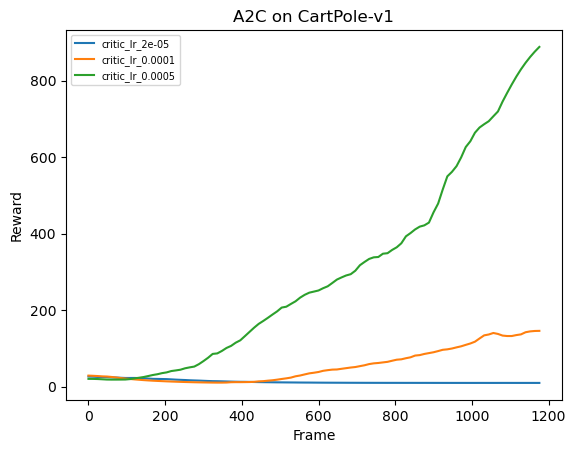

In [16]:
actor_lr = 1e-4
critic_lr = [2e-5, 1e-4, 5e-4]
plt.figure()
for i in range(len(critic_lr)):
    agent = AdvantageActorCritic(128, env.observation_space, env.action_space, actor_lr, critic_lr[i])
    info = train(agent, 1200, 10)
    x, y = info["episodes"], info["rewards"]
    y, x = moving_average(y, x)
    plt.plot(x, y, label='critic_lr_{}'.format(critic_lr[i]))
plt.title('A2C on {}'.format(env_name))
plt.legend(prop={"size": 7})
plt.xlabel("Frame")
plt.ylabel("Reward")
plt.show()

**Questions.**

* What can you infer from the plot about the relationship between the learning rate of critic and actor?
  * We can see that as the learning rate of critic increases, the reward increases significantly. When the learning rate of critic is $2\times 10^{-5}$, the agent can hardly get any reward. When the learning rate is raised to $1\times 10^{-4}$, the agent can get a reward of around $200$, which is still not high enough. When the learning rate is further increased to $5\times 10^{-4}$, the agent can get a reward of around $800$, which is close to the upper bound of the environment.
  * To conclude, with a low learning rate of critic, the agent can hardly learn anything. This is because the actor changes faster than the critic, so the estimated value cannot truly reflect the real value since it is based on the past policy. Therefore, the learning rate of critic should be higher than that of actor to ensure the critic can catch up with the actor and provide a more accurate value estimation.